In [2]:
# Для того, чтобы изменения из .py файлов подгружались сразу без рестарта
%load_ext autoreload
%autoreload 2
%aimport
from scipy import stats
import numpy as np
import pandas as pd
from src.ab import *
from src.bayesian import *
from src.mab import *
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams['figure.figsize'] = [16, 7]
print("Ссылка на описание классического AB-тестирования для базы знаний, \n")
print("https://docs.google.com/document/d/1jlyXvtl3RB1CKtLFXdsZfyx83kpMHrKRaQgsPQIqLNo/edit")

Modules to reload:
all-except-skipped

Modules to skip:

Ссылка на описание классического AB-тестирования для базы знаний, 

https://docs.google.com/document/d/1jlyXvtl3RB1CKtLFXdsZfyx83kpMHrKRaQgsPQIqLNo/edit


# Общий алгоритм классических АB-тестов:

1. Определяем размер выборки
2. Запускаем тест и останавливаем его в момент достаточного числа пользователей
3. Считаем доверительные интервалы и p-value для разницы средних конверсий или ARPU
4. Если вариантов больше 2, то учитываем поправку FDR
5. Делаем вывод о победителях или вывод, что победитель однозначно не определен
6. Если победитель не определен, то можно запустить повторный тест с 5 шагами, описанными выше.


# 7. Пример проведения классического A/B-теста на конверсию


### Определяем размер выборки

$
n = \frac{(z_{\alpha/2} + z_{\beta})^2} {(p_1 - p_2)^2} * p_1 * (1 - p_1) + p_2 * (1-p_2)
$

где $p_1$ - базовая конверсия, $p_2$ - конверсия при предполагаемом эффекте
$z_{\alpha}$ - $\alpha$ квантиль нормального распределения
$z_{\beta}$ - $\beta$ квантиль нормального распределения

In [3]:
p_control_percent, mde_percent = 2, 30
print(f"При ошибке 1 рода в 5% и мощности теста в 80% \nдля базовой конверсии в {p_control_percent}% и ожидаемом минимальном эффекте \n"
      f"в {mde_percent}% необходимое число наблюдений для каждого варианта: \n"
      f"{get_size_zratio(p_control_percent, mde_percent)}")

При ошибке 1 рода в 5% и мощности теста в 80% 
для базовой конверсии в 2% и ожидаемом минимальном эффекте 
в 30% необходимое число наблюдений для каждого варианта: 
9794


In [5]:
ab_classic = ABConversionTest(p_control=2, mde=30)
winner_df, result_df = ab_classic.start_experiment(seed=10000, n_boots=10000)
print(f"Средние конверсии для контрольного варианта: {round(result_df.T['mu1'].values[0] * 100, 2)}%")
print(f"Средние конверсии для тестового варианта: {round(result_df.T['mu2'].values[0] * 100, 2)}%")
print(f"Доверительный интервал z-теста: {(result_df.T['ci_lower_ztest'].values[0], result_df.T['ci_upper_ztest'].values[0])} \n")
print(f"Доверительный интервал при бутстрапе: {(result_df.T['ci_lower_bs'].values[0], result_df.T['ci_upper_bs'].values[0])} \n")
print(f"p-value z-теста: {result_df.T['p_value_zstat'].values[0]} \n")
print(f"p-value бутстрап: {result_df.T['p_value_bs'].values[0]} \n")

Средние конверсии для контрольного варианта: 1.91%
Средние конверсии для тестового варианта: 2.42%
Доверительный интервал z-теста: (-0.009180396502886413, -0.0010299363539647138) 

Доверительный интервал при бутстрапе: (-0.00918929957116602, -0.0009189299571166036) 

p-value z-теста: 0.01409121808037592 

p-value бутстрап: 0.01540000000000008 



`Доверительные интервалы не включают 0.
 Этому выводу эквивалентно, что p-value для бутстрапа меньше ошибки 1 рода в 0.05 (5%).
`

In [7]:
2.42 - 1.91

0.51

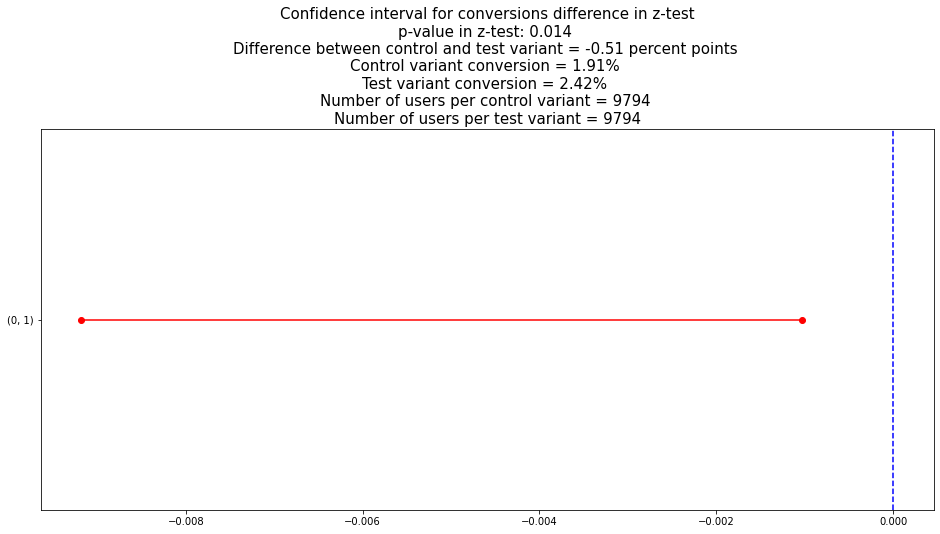

In [13]:
create_confidence_plot(result_df.T, 'ci_lower_ztest', 'ci_upper_ztest')
plt.title(f"Confidence interval for conversions difference in z-test\n"
          f"p-value in z-test: 0.014 \n"
          f"Difference between control and test variant = -0.51 percent points \n"
          f"Control variant conversion = 1.91% \n"
          f"Test variant conversion = 2.42% \n"
          f"Number of users per control variant = 9794 \n"
          f"Number of users per test variant = 9794",
          fontdict={"size": 15});

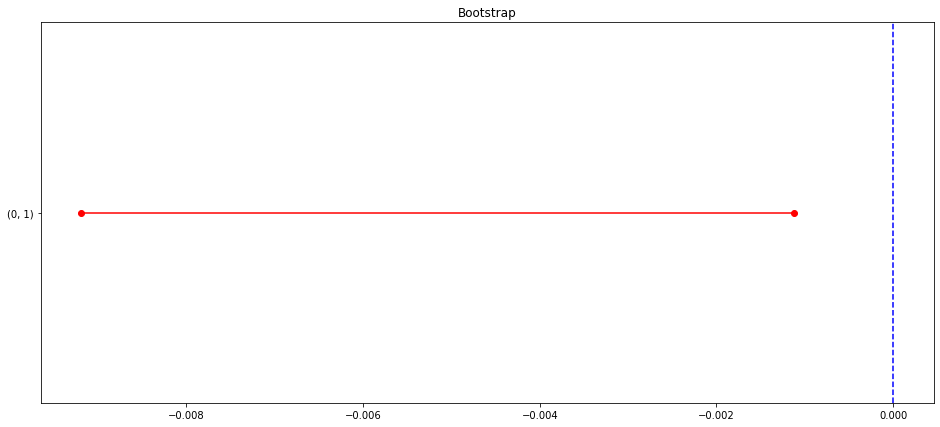

In [108]:
create_confidence_plot(result_df.T, 'ci_lower_bs', 'ci_upper_bs')
plt.title("Bootstrap");

# 8. Пример проведения классического A/B-теста на ARPU


$\mu_1=0.2$, $\mu_2=0.25$, $sd=0.6$

### Определяем размер выборки
$
n = (\sqrt{2} * sd * \frac{z_{\beta} + z_{\alpha}} {\mu_1 - \mu_2}) ^ 2
$

где $\mu_1$ - ARPU для контрольного варианта, $mu_2$ - ARPU при предполагаемом эффекте,
$sd$ - стандартное отклонение для двух вариантов
$z_{\alpha}$ - $\alpha$ квантиль нормального распределения
$z_{\beta}$ - $\beta$ квантиль нормального распределения

In [16]:
mu1, mu2, sd = 0.2, 0.3, 0.6
print(f"При ошибке 1 рода в 5% и мощности теста в 80% \nдля ARPU контрольного варианта {mu1}$ и ожидаемом минимальном эффекте "
      f"в {round((mu2 / mu1 - 1) * 100)}% \nнеобходимое число наблюдений для каждого варианта: "
      f"{get_size_student(mu1, mu2, sd_coef=3)}")
size_arpu = get_size_student(mu1, mu2, sd_coef=3)

При ошибке 1 рода в 5% и мощности теста в 80% 
для ARPU контрольного варианта 0.2$ и ожидаемом минимальном эффекте в 50% 
необходимое число наблюдений для каждого варианта: 565


In [17]:
np.random.seed(1000)
data = np.random.normal([0.2, 0.3],  [0.6, 0.6], size=(size_arpu, 2))
ab_arpu = ABTest(data)
result_df_arpu = ab_arpu.start_experiment()
print(f"ARPU для контрольной и тестовой выборки: {data.mean(axis=0)}")
print(f"Доверительный интервал t-теста Стьюдента: {(result_df_arpu.T['ci_lower_Student'].values[0], result_df_arpu.T['ci_upper_Student'].values[0])} \n")
print(f"Доверительный интервал при бутстрапе: {(result_df_arpu.T['ci_lower_bootstrap'].values[0], result_df_arpu.T['ci_upper_bootstrap'].values[0])} \n")
print(f"p-value t-теста: {result_df_arpu.T['p_value_Student'].values[0]} \n")
print(f"p-value бутстрап: {result_df_arpu.T['p_value_bootstrap'].values[0]} \n")

ARPU для контрольной и тестовой выборки: [0.208 0.294]
Доверительный интервал t-теста Стьюдента: (-0.1556705352557367, -0.014961973617745497) 

Доверительный интервал при бутстрапе: (-0.1538616092265826, -0.01430461267838767) 

p-value t-теста: 0.01750946663216369 

p-value бутстрап: 0.016000000000000014 



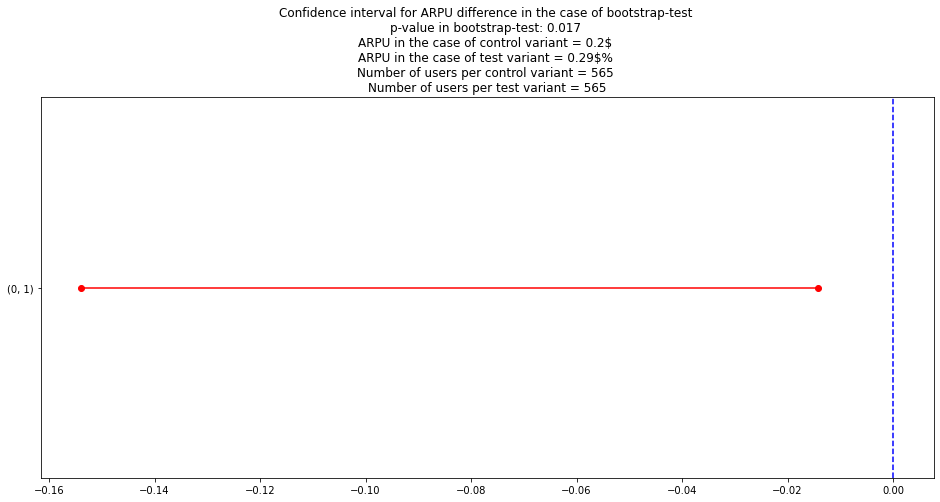

In [18]:
create_confidence_plot(result_df_arpu.T, 'ci_lower_bootstrap', 'ci_upper_bootstrap');
plt.title(f"Confidence interval for ARPU difference in the case of bootstrap-test \n"
          f"p-value in bootstrap-test: 0.017 \n"
          f"ARPU in the case of control variant = 0.2$ \n"
          f"ARPU in the case of test variant = 0.29$% \n"
          f"Number of users per control variant = 565 \n"
          f"Number of users per test variant = 565");

# Проблемы в классических AB-тестах

## Подглядывание

Давайте проведем А/А тест - будем показывать одним и тем же пользователям одинаковые дизайны приложений.
Допустим наш эксперимент на конверсию длится 2 недели. В среднем число пользователей за день составляет около 700.
Давайте посмотрим, как будут изменяться наши доверительные интервалы на конец каждого дня.

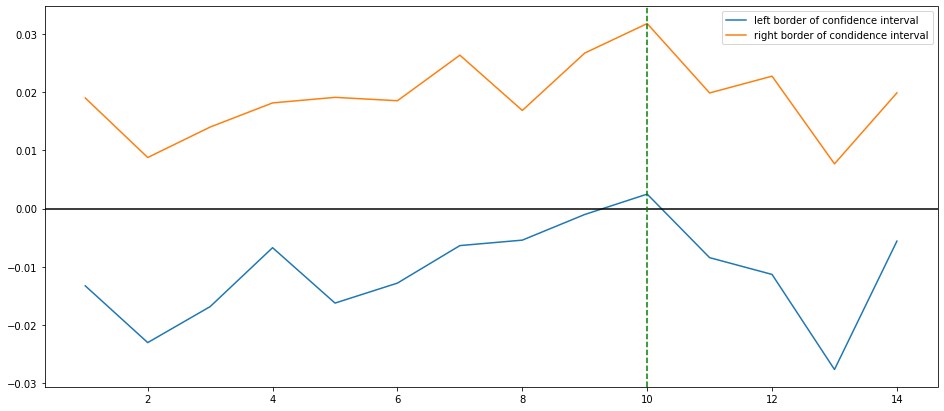

In [16]:
np.random.seed(1000)
left_ci, right_ci = [], []
for day in range(1, 15):
    data = np.random.binomial(n=[1] * 2, p=[0.02, 0.02],
                              size=(700, 2))
    cm = sms.CompareMeans(sms.DescrStatsW(data[:, 0]),
                          sms.DescrStatsW(data[:, 1]))
    conf = cm.tconfint_diff(usevar='unequal', alpha=0.05)
    left_ci.append(conf[0])
    right_ci.append(conf[1])
df = pd.DataFrame(index=np.arange(1, 15), 
                  columns=['left border of confidence interval', 'right border of condidence interval'])
df['left border of confidence interval'] = left_ci
df['right border of confidence interval'] = right_ci
df.plot();
plt.axhline(0, color='black', );
plt.axvline(10, color = "green", linestyle='--');


Из графика видно,что на 10 день теста мы получили статистически значимые различия между вариантами теста - доверительные интервалы для разницы средних
вышли за пределы нулевого значения.
Таким образом, из-за ошибки подглядывания мы нашли победителя, когда на самом деле его быть не должно - мы совершили ошибку 1 рода.